# Image registration

In some cases a calibration image of a field containing a lot of stars obtained with SITELLE in the same filter and during the same run as the science data can be used to compute a distortion model that can be then used directly to enhance the astrometrical calibration of the science cube which may have much less stars. The distortion model is then kept as is and only the basic registration parameters are recomputed (see Martin el al. 2017, http://adsabs.harvard.edu/abs/2017arXiv170701366M)

In [4]:
from orb.astrometry import Astrometry
import orb.utils.io as io
from orb.core import Logger

## Initial calibration
`target_radec` and `target_xy` are the initial coordinates of the registration procedure. They must be taken near the center of the image to register and can be obtained using, e.g. the Digital Sky Survey (http://archive.stsci.edu/cgi-bin/dss_form).

**warning** don't forget that ds9 is indexed (1,1) and python is indexed (0,0). i.e. you must subtract 1 to x and y image coordinates if you read your image with ds9.

**note: This process is best done two times. The first time only the center of the field of view is considered and a rough primary distortion field is obtained that can be used the second time to compute a distortion model over the whole field of view**. Here it is done only once for the sake of clarity.

In [5]:
Logger() # used to get clean log info
data = io.read_fits('M1-71_SN3.merged.InterferogramMerger.deep_frame.fits')
wcs = Astrometry(data, instrument='sitelle', target_radec=(294.1120729, 19.70678597), 
                               target_xy=(1036, 1032)).register(compute_distortion=True)

 [==========] [100%] [completed in 3.00 s]                                    


/home/thomas/Astro/Python/ORB/Orb/orb/utils/astrometry.py:2034: UserWarning: CD_ij based WCS is not recommended. Please prefer a PC_ij representation.
  warnings.warn('CD_ij based WCS is not recommended. Please prefer a PC_ij representation.')
/home/thomas/Astro/Python/ORB/Orb/orb/astrometry.py:2085: UserWarning: As no prior SIP has been given, this initial SIP is computed over the field inner circle. To cover the whole field the result of this registration must be passed at the definition of the class
  warnings.warn('As no prior SIP has been given, this initial SIP is computed over the field inner circle. To cover the whole field the result of this registration must be passed at the definition of the class')


/home/thomas/Astro/Python/ORB/Orb/orb/utils/astrometry.py:580: UserWarning: fit_star leastsq exception: Improper input: N=3 must not exceed M=0
  warnings.warn('fit_star leastsq exception: {}'.format(e))
/home/thomas/Astro/Python/ORB/Orb/orb/utils/astrometry.py:1861: UserWarning: 'WCS.all_world2pix' failed to converge to the requested accuracy.
After 20 iterations, the solution is diverging at least for one input point.
  warnings.warn(str(e))
/home/thomas/Astro/Python/ORB/Orb/orb/utils/astrometry.py:1861: UserWarning: 'WCS.all_world2pix' failed to converge to the requested accuracy.
After 3 iterations, the solution is diverging at least for one input point.
  warnings.warn(str(e))
/home/thomas/Astro/Python/ORB/Orb/orb/utils/astrometry.py:1861: UserWarning: 'WCS.all_world2pix' failed to converge to the requested accuracy.
After 10 iterations, the solution is diverging at least for one input point.
  warnings.warn(str(e))
/home/thomas/Astro/Python/ORB/Orb/orb/utils/astrometry.py:1861: U

/home/thomas/Astro/Python/ORB/Orb/orb/astrometry.py:2163: RuntimeWarning: invalid value encountered in greater
  _x[np.nonzero(_r > rmax)] = np.nan


In [6]:
io.write_fits('M1-71.deep_frame.wcs.init.fits', data, fits_header=wcs.to_header(relax=True), overwrite=True)

'M1-71.deep_frame.wcs.init.fits'

## Final calibration

The obtained wcs is used as an input for the final calibration. Now the whole field of view can be considered.

In [7]:
print wcs
target_radec = wcs.wcs.crval
target_xy = wcs.wcs.crpix
import orb.utils.astrometry
wcs_rotation = orb.utils.astrometry.get_wcs_parameters(wcs)[-1]
print wcs_rotation

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 294.11207289999999  19.706785969999999  
CRPIX : 1037.7277545623001  1035.9003861412  
PC1_1 PC1_2  : -8.9800592910422e-05  -1.8004417444403e-06  
PC2_1 PC2_2  : -1.8004417444403e-06  8.9800592910422e-05  
CDELT : 1.0  1.0  
NAXIS : 0  0
1.14858812074


/home/thomas/.virtualenvs/orb/local/lib/python2.7/site-packages/astropy/wcs/wcs.py:2729: RuntimeWarning: cdelt will be ignored since cd is present
  description.append(s.format(*self.wcs.cdelt))


In [8]:
wcs, dxmap, dymap = Astrometry(data, instrument='sitelle', target_radec=target_radec, 
                               target_xy=target_xy,  wcs_rotation=wcs_rotation, sip=wcs).register(
                                    compute_distortion=True, return_error_maps=True)


 [==========] [100%] [completed in 2.97 s]                                    





In [9]:
io.write_fits('M1-71.deep_frame.wcs.best.fits', data, fits_header=wcs.to_header(relax=True), overwrite=True)
io.write_fits('M1-71.wcs.dxmap.fits', dxmap, overwrite=True)
io.write_fits('M1-71.wcs.dymap.fits', dymap, overwrite=True)

'M1-71.wcs.dymap.fits'

## Check the results

You might want to check the quality of the calibration by choosing a catalog and plot the positions of the stars with the wcs only and with the micro-shifting maps (dxmap, dymap).

In [10]:
# load files and query the catalog
import orb.utils.web
import numpy as np
im, hdr = io.read_fits('M1-71.deep_frame.wcs.best.fits', return_header=True)
dxmap = io.read_fits('M1-71.wcs.dxmap.fits')
dymap = io.read_fits('M1-71.wcs.dymap.fits')

star_list_deg = orb.utils.web.query_vizier(8, hdr['CRVAL1'], hdr['CRVAL2'],
                                           catalog='gaia', max_stars=5000)

### Only the WCS (SIP but no dx/dy maps)

In [11]:
# this is a very basic filter to remove stars position which are out of the image
def filter_star_list(_star_list):
    _star_list = np.copy(_star_list)
    for istar in range(_star_list.shape[0]):
        if (_star_list[istar,0] < 0
            or _star_list[istar,0] > 2048
            or _star_list[istar,1] < 0
            or _star_list[istar,1] > 2064):
            _star_list[istar,:] = np.nan
    return _star_list

In [12]:
dxmap_null = np.copy(dxmap)
dxmap_null.fill(0.)
dymap_null = np.copy(dymap)
dymap_null.fill(0.)

star_list_pix1 = orb.utils.astrometry.world2pix(
    hdr, im.shape[0], im.shape[1], np.copy(star_list_deg), dxmap_null, dymap_null)

star_list_pix1 = filter_star_list(star_list_pix1)

/home/thomas/.virtualenvs/orb/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


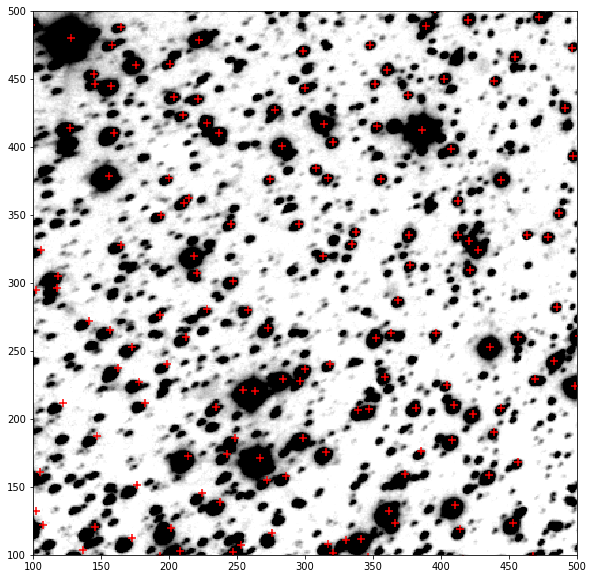

In [13]:
# inline plotting for jupyter notebook. Do not put this line in a real python script.
%matplotlib inline
import pylab as pl

fig = pl.figure(figsize=(10,10))

pl.imshow(im.T,
          vmin=np.nanpercentile(im, 50),
          vmax=np.nanpercentile(im, 90),
          cmap='gray_r', interpolation='None', origin='bottom-left')

pl.xlim((100,500))
pl.ylim((100,500))
pl.axes().set_aspect('equal')

pl.scatter(star_list_pix1[:,0], star_list_pix1[:,1], c='red', marker='+', s=80, linewidths=1.5)

### WCS + dx/dy maps

Only a SIP model is not enough to get a precision of the order of the pixel because the field is strongly distorted on the borders. Micro-shifting maps (`dxmap` and `dymap`) can thus help in attaining a really good precision on the astrometry.

In [14]:
star_list_pix2 = orb.utils.astrometry.world2pix(
    hdr, im.shape[0], im.shape[1], np.copy(star_list_deg), dxmap, dymap)

star_list_pix2 = filter_star_list(star_list_pix2)

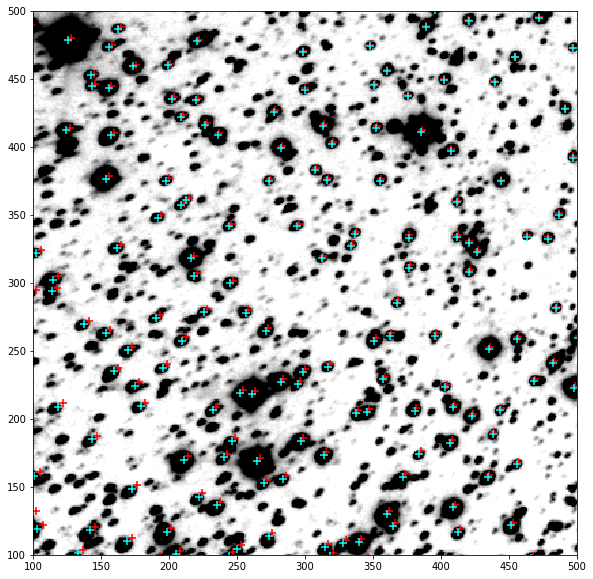

In [15]:
# inline plotting for jupyter notebook. Do not put this line in a real python script.
%matplotlib inline
import pylab as pl

fig = pl.figure(figsize=(10,10))

pl.imshow(im.T,
          vmin=np.nanpercentile(im, 50),
          vmax=np.nanpercentile(im, 90),
          cmap='gray_r', interpolation='None', origin='bottom-left')

pl.xlim((100,500))
pl.ylim((100,500))
pl.axes().set_aspect('equal')

pl.scatter(star_list_pix1[:,0], star_list_pix1[:,1], c='red', marker='+', s=80, linewidths=1.5)
pl.scatter(star_list_pix2[:,0], star_list_pix2[:,1], c='cyan', marker='+', s=80, linewidths=1.5)